# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from scipy.stats import norm

# Data Import

In [2]:
dataset = pd.read_csv("Desktop/Student_Performance.csv")

##### Optional Drop Column

In [3]:
# Remove the column you want to drop
#column_to_drop = "case"  # Replace "column_name" with the name of the column you want to remove
#dataset.drop(columns=[column_to_drop], inplace=True)


# Data Cleaning

In [4]:
dataset.info()
#Distribution
dataset.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


,count,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Sleep Hours,10000.0,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0


### Null Values

In [5]:
dataset.isna().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [6]:
# Calculate the threshold for the number of missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the number of missing values is less than the threshold, drop rows
        if dataset[column].isna().sum() < threshold:
            dataset = dataset.dropna(subset=[column])
        # If the number of missing values is greater than or equal to the threshold, fill with mean
        else:
            dataset[column].fillna(dataset[column].mean(), inplace=True)

In [7]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

## Identify Target Variable

In [8]:
target = 'Performance Index'

# Feature Engineering 

### One Hot Encoder

In [9]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(dataset.select_dtypes(include=['object']).columns.tolist())

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
    # Display the modified dataset
    print("Modified Dataset:")
    print(dataset.head())
else:
    print("No categorical columns found.")


Categorical columns found:
Hours Studied
Extracurricular Activities
Sleep Hours
Modified Dataset:
   Previous Scores  Sample Question Papers Practiced  Performance Index  \
0               99                                 1               91.0   
1               82                                 2               65.0   
2               51                                 2               45.0   
3               52                                 2               36.0   
4               75                                 5               66.0   

   Hours Studied_2  Hours Studied_3  Hours Studied_4  Hours Studied_5  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              1.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              1.0   
4              0.0              0.0              0.0              0.0   

   Hours Stu

In [10]:
# Calculate the threshold for the number of missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the number of missing values is less than the threshold, drop rows
        if dataset[column].isna().sum() < threshold:
            dataset = dataset.dropna(subset=[column])
        # If the number of missing values is greater than or equal to the threshold, fill with mean
        else:
            dataset[column].fillna(dataset[column].mean(), inplace=True)

In [11]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

### Outlier Detection

#### *** Data is scaled at this step***

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 2 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]


Indices of outliers: [4154 5567 6197]
Details of outliers:
      Previous Scores  Sample Question Papers Practiced  Performance Index  \
4154               40                                 0               17.0   
5567               98                                 0               72.0   
6197               40                                 0               17.0   

      Hours Studied_2  Hours Studied_3  Hours Studied_4  Hours Studied_5  \
4154              0.0              1.0              0.0              0.0   
5567              0.0              1.0              0.0              0.0   
6197              0.0              1.0              0.0              0.0   

      Hours Studied_6  Hours Studied_7  Hours Studied_8  Hours Studied_9  \
4154              0.0              0.0              0.0              0.0   
5567              0.0              0.0              0.0              0.0   
6197              0.0              0.0              0.0              0.0   

      Extracurricu

### Binary Variables

In [14]:
binary_variables = []

# Iterate through each column
for column in dataset.columns:
    # Check if the number of unique values is 2 and values are 0 and 1, or if the value is just 0
    if (dataset[column].nunique() == 2 and set(dataset[column]) == {0, 1}) or (dataset[column].nunique() == 1 and set(dataset[column]) == {0}):
        binary_variables.append(column)

# Print binary variables
print("Binary Variables:")
print(binary_variables)

Binary Variables:
['Hours Studied_2', 'Hours Studied_3', 'Hours Studied_4', 'Hours Studied_5', 'Hours Studied_6', 'Hours Studied_7', 'Hours Studied_8', 'Hours Studied_9', 'Extracurricular Activities_Yes', 'Sleep Hours_5', 'Sleep Hours_6', 'Sleep Hours_7', 'Sleep Hours_8', 'Sleep Hours_9']


## Numerical to Binary Variables

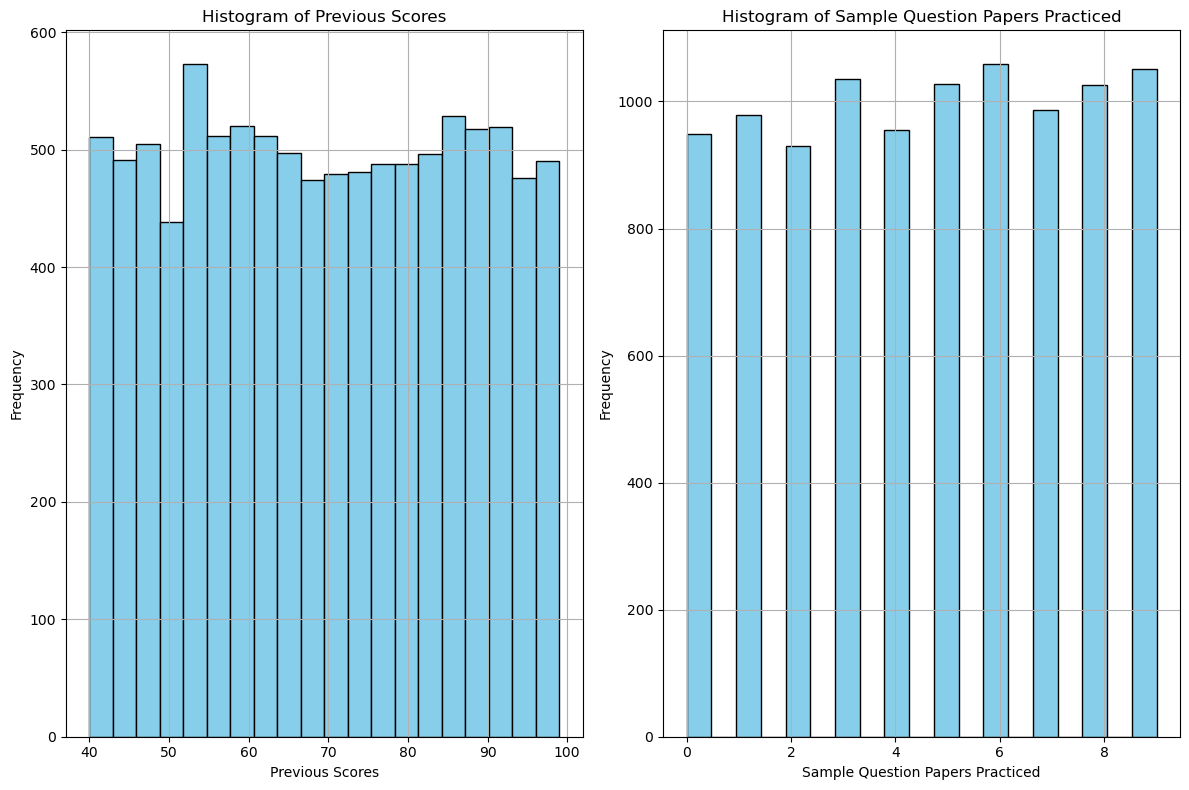

In [15]:
# Get numerical variables
numerical_variables = dataset.select_dtypes(include=['int64', 'float64']).columns
numerical_variables = numerical_variables.drop(target)
numerical_variables = numerical_variables.difference(binary_variables).difference(categorical_columns)

# Calculate number of bins for each numerical variable
num_bins_dict = {}
for column in numerical_variables:
    # Calculate the number of bins using Freedman-Diaconis rule
    q75, q25 = dataset[column].quantile([0.75, 0.25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(dataset[column]) ** (1/3))
    
    # Check if bin_width is zero
    if bin_width == 0:
        # Set a default number of bins or handle it appropriately
        num_bins = 10  # Default value
    else:
        num_bins = int((dataset[column].max() - dataset[column].min()) / bin_width)
        
    # Ensure num_bins is an integer value
    num_bins = int(num_bins)
    
    num_bins_dict[column] = num_bins

# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Calculate the number of rows and columns for subplots
num_variables = len(numerical_variables)
num_rows = int(np.ceil(num_variables / 2))
num_cols = 2

# Initialize figure for histograms
plt.figure(figsize=(12, 8))

# Iterate through each numerical variable
for i, column in enumerate(numerical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Plot histogram
    plt.hist(dataset[column], bins=num_bins_dict[column], color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)
    
# Display the histograms
plt.tight_layout()
plt.show()

In [16]:
# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Iterate through each numerical variable
for column in numerical_variables:
    # Calculate the maximum number of bins for this column
    max_bins_column = num_bins_dict[column]
    
    # Bin the data accordingly
    bins, bin_edges = pd.cut(dataset[column], bins=max_bins_column, retbins=True)
    
    # Generate bin labels from the bin edges
    bin_labels = [f"{column}_{int(bin_edges[i])}_{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
    
    # Encode bins using one-hot encoding
    encoded_bins = pd.get_dummies(bins, prefix=column)
    
    # Rename columns with integer bin edges
    encoded_bins.columns = bin_labels
    
    # Concatenate encoded bins to the binned dataset
    binned_dataset = pd.concat([binned_dataset, encoded_bins], axis=1)

# Display the first few rows of the binned dataset
print("Binned Dataset:")
print(binned_dataset.head())


Binned Dataset:
   Previous Scores_39_42  Previous Scores_42_45  Previous Scores_45_48  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   Previous Scores_48_51  Previous Scores_51_54  Previous Scores_54_57  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      1                      0                      0   
3                      0                      1                      0   
4                      0                      0                      0   

   Previous Scores_57_60  Previous Scores_60_63  Previous Scores_63_66  \
0                   

In [17]:
# Check for duplicate column names
duplicate_columns = binned_dataset.columns[binned_dataset.columns.duplicated()]

# Print duplicate column names, if any
if len(duplicate_columns) > 0:
    print("Duplicate column names found:")
    for column in duplicate_columns:
        print(column)
    
    # Merge duplicate columns
    binned_dataset = binned_dataset.groupby(level=0, axis=1).sum()
    
    print("Duplicate columns merged.")
else:
    print("No duplicate column names found.")

Duplicate column names found:
Sample Question Papers Practiced_0_0
Duplicate columns merged.


In [18]:
# Drop numerical columns from the original dataset
dataset.drop(columns=numerical_variables, inplace=True)

# Concatenate binned_dataset with the original dataset
dataset = pd.concat([dataset, binned_dataset], axis=1)

# Display the updated dataset
print("Updated Dataset:")
print(dataset.head())

Updated Dataset:
   Performance Index  Hours Studied_2  Hours Studied_3  Hours Studied_4  \
0               91.0              0.0              0.0              0.0   
1               65.0              0.0              0.0              1.0   
2               45.0              0.0              0.0              0.0   
3               36.0              0.0              0.0              0.0   
4               66.0              0.0              0.0              0.0   

   Hours Studied_5  Hours Studied_6  Hours Studied_7  Hours Studied_8  \
0              0.0              0.0              1.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              1.0   
3              1.0              0.0              0.0              0.0   
4              0.0              0.0              1.0              0.0   

   Hours Studied_9  Extracurricular Activities_Yes  ...  \
0              0.0                

In [19]:
# Calculate column sums
#column_sums = dataset.sum()

# Get column names where sum is less than 10
#columns_to_remove = column_sums[column_sums < 10].index

# Remove columns from dataset
#dataset = dataset.drop(columns=columns_to_remove)

print("Number of columns in the dataset:", len(dataset.columns))

Number of columns in the dataset: 53


### Up-Sampling

In [20]:
# Iterate over columns starting with "X"
for column in dataset.columns:
    if column.startswith("Extracurricular Activities"):
        # Get the target column
        upsamp_target = dataset[column]
        
        # Get the sorted value counts
        target_counts_sorted = upsamp_target.value_counts().sort_index()

        # Display the counts
        print(f"Target Value Counts for {column} (Sorted):")
        print(target_counts_sorted)


Target Value Counts for Extracurricular Activities_Yes (Sorted):
0.0    5050
1.0    4947
Name: Extracurricular Activities_Yes, dtype: int64


In [ ]:
# Select rows where the value in the target column is equal to 1
df_majority = dataset[dataset["sex_m"] == 1]


# Select rows where the value in the target column is equal to 0
df_minority = dataset[dataset["sex_m"] == 0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset["sex_m"].value_counts())

# Dimensionality Reduction

In [21]:
#Check for perfect multicollinearity
correlation_matrix = dataset.corr()
highly_correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(colname_i)
            highly_correlated_variables.add(colname_j)
print("Highly correlated variables:", highly_correlated_variables)

# Step 2: Remove constant variables
constant_variables = [col for col in dataset.columns if dataset[col].nunique() == 1]
print("Constant variables:", constant_variables)
dataset.drop(columns=constant_variables, inplace=True)

# Define the target variable 'y'
y = dataset[target]

# Select all other columns as features 'x'
X = dataset.drop(columns=[target])

Highly correlated variables: set()
Constant variables: ['Sample Question Papers Practiced_1_1', 'Sample Question Papers Practiced_2_2', 'Sample Question Papers Practiced_3_3', 'Sample Question Papers Practiced_4_4', 'Sample Question Papers Practiced_5_5', 'Sample Question Papers Practiced_6_6', 'Sample Question Papers Practiced_7_7', 'Sample Question Papers Practiced_8_8']


### Principal Component Analysis (PCA)

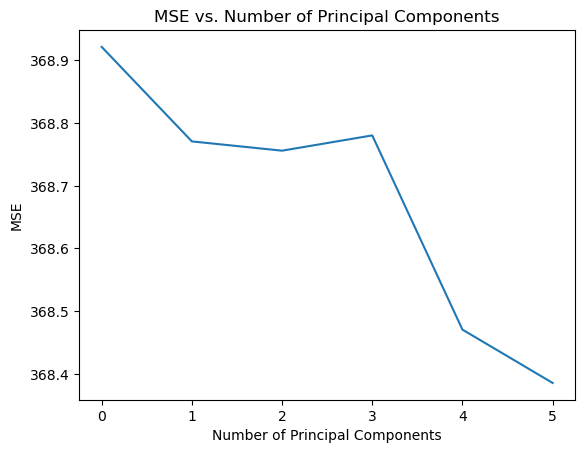

In [22]:

# Perform PCA
pca = PCA()
x_reduced = pca.fit_transform(X)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Initialize linear regression model
regr = LinearRegression()

# Calculate MSE with only the intercept
mse = []
score = -1 * model_selection.cross_val_score(regr,
                                              np.ones((len(x_reduced), 1)), y, cv=cv,
                                              scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1 * model_selection.cross_val_score(regr,
                                                  x_reduced[:, :i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)


# Plot cross-validation results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Principal Components')
plt.show()

In [23]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 7.  , 11.95, 16.64, 21.24, 25.76, 28.95, 32.12, 35.27, 38.38,
       41.46, 44.52, 47.56, 50.48, 53.36, 56.22, 59.06, 61.84, 64.56,
       67.23, 69.87, 72.47, 74.05, 75.52, 76.96, 78.4 , 79.83, 81.25,
       82.67, 84.08, 85.48, 86.86, 88.23, 89.59, 90.95, 92.31, 93.65,
       94.98, 96.31, 97.63, 98.85, 99.6 , 99.95, 99.95, 99.95])

In [24]:
# Choose the desired number of principal components based on the plot
num_components = 48 # For example, choose n principal components

# Use the selected number of principal components
x_reduced_selected = x_reduced[:, :num_components]

# Splitting the dataset

In [25]:
from sklearn.model_selection import train_test_split

# Split the data into training (50%), testing (30%), and out-of-sample (20%)
x_train, x_temp, y_train, y_temp = train_test_split(x_reduced_selected, y, test_size=0.4, random_state=100)
x_test, x_out_sample, y_test, y_out_sample = train_test_split(x_temp, y_temp, test_size=0.6, random_state=100)

# Fitting the Multiple Linear Regression model

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define the model
mlr = LinearRegression()

# Define an empty hyperparameter grid
param_grid = {}

# Define the GridSearchCV with an empty hyperparameter grid
grid_search = GridSearchCV(mlr, param_grid, cv=5, scoring=make_scorer(r2_score)) #cv=3 small datasets, cv=5 larger

# Fit the model with hyperparameter optimization
grid_search.fit(x_train, y_train)

# Get the best estimator
best_mlr = grid_search.best_estimator_

# Train the best model on the entire training set (Optional)
best_mlr.fit(x_train, y_train)

LinearRegression()

# Prediction of test set

In [27]:
y_pred_mlr = best_mlr.predict(x_test)

In [35]:
y_pred_out_sample = best_mlr.predict(x_out_sample)

# Actual value and the predicted value

In [28]:
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()
print(mlr_diff)

      Actual value  Predicted value
613           40.0        43.461111
3859          72.0        74.216707
731           46.0        44.983201
6776          72.0        73.427988
7303          56.0        53.374416
...            ...              ...
1011          52.0        49.122483
3986          88.0        88.666722
7086          38.0        41.382237
6142          63.0        63.189582
5447          62.0        62.338241

[1599 rows x 2 columns]


# Model Evaluation

### On test data

In [38]:
from sklearn import metrics
r_squared = best_mlr.score(x_test, y_test)
print('R squared: {:.2f}'.format(r_squared * 100))

R squared: 98.69


In [31]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_mlr)
print('Mean squared error: {:.2f}'.format(mse))

Mean squared error: 4.84


In [32]:
from sklearn.metrics import max_error
me = max_error(y_test, y_pred_mlr)
print('Max error: {:.2f}'.format(me))

Max error: 7.02


### On out-of-sample data

In [33]:
r_squared = best_mlr.score(x_out_sample, y_out_sample)
print('R squared: {:.2f}'.format(r_squared * 100))

R squared: 98.70


In [36]:
mse = mean_squared_error(y_out_sample, y_pred_out_sample)
print('Mean squared error: {:.2f}'.format(mse))

Mean squared error: 4.94


In [37]:
me = max_error(y_out_sample, y_pred_out_sample)
print('Max error: {:.2f}'.format(me))

Max error: 8.68


## Fairness

In [39]:
# Create DataFrame for predicted values
y_pred_mlr_df = pd.DataFrame({'Predicted value': y_pred_mlr})

# Reset the index of the original_data DataFrame to ensure alignment
original_data_reset_index = dataset.reset_index(drop=True)

# Filter out rows with NaN predicted values
joined_data = pd.concat([original_data_reset_index, y_pred_mlr_df], axis=1)
joined_data = joined_data[~np.isnan(joined_data['Predicted value'])]

# Display the joined data
print(joined_data.head())


   Performance Index  Hours Studied_2  Hours Studied_3  Hours Studied_4  \
0               91.0              0.0              0.0              0.0   
1               65.0              0.0              0.0              1.0   
2               45.0              0.0              0.0              0.0   
3               36.0              0.0              0.0              0.0   
4               66.0              0.0              0.0              0.0   

   Hours Studied_5  Hours Studied_6  Hours Studied_7  Hours Studied_8  \
0              0.0              0.0              1.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              1.0   
3              1.0              0.0              0.0              0.0   
4              0.0              0.0              1.0              0.0   

   Hours Studied_9  Extracurricular Activities_Yes  ...  \
0              0.0                             1.0 

In [ ]:
# Calculate absolute error
absolute_error = abs(joined_data[target] - joined_data['Predicted value'])

# Avoid division by zero
error_rate = absolute_error / np.where(joined_data[target] != 0, joined_data[target], np.nan)

# Add error rate as a new column to the dataset
joined_data['Error Rate'] = error_rate

print(joined_data.head())

In [ ]:
# Filter rows where sex_M is equal to 0
error_rate_sex_M_0 = joined_data[joined_data['sex_male'] == 0]['Error Rate'].fillna(0).median()
# Filter rows where sex_M is equal to 1
error_rate_sex_M_1 = joined_data[joined_data['sex_male'] == 1]['Error Rate'].median()

print(f'Error rate mean for sex_male = 0: {error_rate_sex_M_0}')
print(f'Error rate mean for sex_male = 1: {error_rate_sex_M_1}')


# Outlier Model

### Up-Sampling

In [ ]:
# Iterate over columns starting with "X"
for column in dataset.columns:
    if column.startswith("sex"):
        # Get the target column
        upsamp_target = outliers_dataset[column]
        
        # Get the sorted value counts
        target_counts_sorted = upsamp_target.value_counts().sort_index()

        # Display the counts
        print(f"Target Value Counts for {column} (Sorted):")
        print(target_counts_sorted)
        

In [ ]:
# Select rows where the value in the target column is equal to 1
df_majority = outliers_dataset[outliers_dataset["sex_male"] == 1]


# Select rows where the value in the target column is equal to 0
df_minority = outliers_dataset[outliers_dataset["sex_male"] == 0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
outliers_dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset["sex_male"].value_counts())

## Dimensionality Reduction

### PCA

In [ ]:
oX = outliers_dataset.drop(columns=[target])
oy = outliers_dataset[target]

# Perform PCA
pca = PCA()
ox_reduced = pca.fit_transform(oX)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Initialize linear regression model
regr = LinearRegression()

# Calculate MSE with only the intercept
mse = []
score = -1 * model_selection.cross_val_score(regr,
                                              np.ones((len(ox_reduced), 1)), oy, cv=cv,
                                              scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1 * model_selection.cross_val_score(regr,
                                                  ox_reduced[:, :i], oy, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

# Choose the desired number of principal components based on the plot
num_components = 12  # For example, choose n principal components

# Use the selected number of principal components
ox_reduced_selected = ox_reduced[:, :num_components]

# Plot cross-validation results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Principal Components')
plt.show()

In [ ]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

## Splitting the outlier dataset

In [ ]:
oX = outliers_dataset.drop(columns=[target])
oy = outliers_dataset[target]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training (50%), testing (30%), and out-of-sample (20%)
ox_train, ox_temp, oy_train, oy_temp = train_test_split(ox_reduced_selected, oy, test_size=0.3, random_state=100)
ox_test, ox_out_sample, oy_test, oy_out_sample = train_test_split(ox_temp, oy_temp, test_size=0.6, random_state=100)

## Fitting the Multiple Linear Regression Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define the model
mlr = LinearRegression()

# Define an empty hyperparameter grid
param_grid = {}

# Define the GridSearchCV with an empty hyperparameter grid
grid_search = GridSearchCV(mlr, param_grid, cv=5, scoring=make_scorer(r2_score))

# Fit the model with hyperparameter optimization
grid_search.fit(ox_train, oy_train)

# Get the best estimator
best_mlr = grid_search.best_estimator_

# Train the best model on the entire training set
best_mlr.fit(ox_train, oy_train)

## Prediction of test set

In [ ]:
oy_pred_mlr = best_mlr.predict(ox_test)

## Actual Value and Predicted Value

In [ ]:
mlr_diff = pd.DataFrame({'Actual value': oy_test, 'Predicted value': oy_pred_mlr})
mlr_diff.head()

## Model Evaluation

### On test data

In [ ]:
from sklearn import metrics
r_squared = best_mlr.score(ox_test, oy_test)
print('R squared: {:.2f}'.format(r_squared * 100))

In [ ]:
mse = mean_squared_error(oy_test, oy_pred)
print('Mean squared error: {:.2f}'.format(mse * 100))

In [ ]:
me = max_error(oy_test, oy_pred)
print('Max error: {:.2f}'.format(me * 100))

### On out-of-sample data

In [ ]:
r_squared = best_mlr.score(ox_out_sample, oy_out_sample)
print('R squared: {:.2f}'.format(r_squared * 100))

In [ ]:
mse = mean_squared_error(oy_out_sample, y_pred_out_sample)
print('Mean squared error: {:.2f}'.format(mse))

In [ ]:
me = max_error(oy_out_sample, y_pred_out_sample)
print('Max error: {:.2f}'.format(me))

In [ ]:
oy_pred_mlr_df = pd.DataFrame({'Predicted value': oy_pred_mlr})

# Reset the index of the original_data DataFrame to ensure alignment
ooriginal_data_reset_index = outliers_dataset.reset_index(drop=True)

# Concatenate original_data_reset_index, y_test_df, and y_pred_mlr_df along the columns
ojoined_data = pd.concat([original_data_reset_index, oy_pred_mlr_df], axis=1)

# Display the joined data
print(ojoined_data.head())

In [ ]:
# Calculate absolute error
absolute_error = abs(ojoined_data[target] - ojoined_data['Predicted value'])

# Calculate error rate
error_rate = absolute_error / ojoined_data[target]

# Add error rate as a new column to the dataset
ojoined_data['Error Rate'] = error_rate
ojoined_data = ojoined_data[~np.isnan(ojoined_data['Predicted value'])]

print(ojoined_data.head())

# Combined Model

In [ ]:
combined_data = pd.concat([ojoined_data, joined_data], axis=0)

# Reset index after concatenation
combined_data.reset_index(drop=True, inplace=True)

# Display the combined dataset
print(combined_data)